In [ ]:
import json
import pandas as pd

def generate_endpoint_description(path, method, endpoint_data):
    description_parts = []

    description_parts.append(f"El endpoint es {method} {path}.")

    if 'summary' in endpoint_data:
        description_parts.append(f"Su resumen es: {endpoint_data['summary']}.")
    if 'description' in endpoint_data:
        description_parts.append(f"Su descripción detallada es: {endpoint_data['description']}.")

    if 'parameters' in endpoint_data:
        param_descs = []
        for param in endpoint_data['parameters']:
            param_name = param.get('name', 'N/A')
            param_in = param.get('in', 'N/A')
            param_desc = param.get('description', '')
            param_required = 'requerido' if param.get('required', False) else 'opcional'
            param_type = param.get('schema', {}).get('type', 'N/A')
            param_format = param.get('schema', {}).get('format', '')
            param_descs.append(f"{param_name} ({param_in}, {param_required}, tipo: {param_type} {param_format if param_format else ''}) - {param_desc}")
        if param_descs:
            description_parts.append("Los parámetros son: " + "; ".join(param_descs) + ".")

    if 'requestBody' in endpoint_data and 'content' in endpoint_data['requestBody']:
        for media_type, content in endpoint_data['requestBody']['content'].items():
            if 'schema' in content and 'properties' in content['schema']:
                req_props = []
                for prop_name, prop_data in content['schema']['properties'].items():
                    prop_type = prop_data.get('type', 'N/A')
                    prop_desc = prop_data.get('description', '')
                    req_props.append(f"{prop_name} (tipo: {prop_type}) - {prop_desc}")
                if req_props:
                    description_parts.append(f"El cuerpo de la solicitud ({media_type}) incluye propiedades: " + "; ".join(req_props) + ".")

    if 'responses' in endpoint_data:
        response_descs = []
        for status_code, response_data in endpoint_data['responses'].items():
            resp_desc = response_data.get('description', '')
            schema_props = []
            if 'content' in response_data:
                for media_type, content in response_data['content'].items():
                    if 'schema' in content and 'properties' in content['schema']:
                        for prop_name, prop_data in content['schema']['properties'].items():
                            prop_type = prop_data.get('type', 'N/A')
                            prop_desc = prop_data.get('description', '')
                            schema_props.append(f"{prop_name} (tipo: {prop_type}) - {prop_desc}")
            if schema_props:
                response_descs.append(f"Respuesta {status_code}: {resp_desc}. Su esquema de respuesta incluye: " + "; ".join(schema_props) + ".")
            else:
                response_descs.append(f"Respuesta {status_code}: {resp_desc}.")
        if response_descs:
            description_parts.append("Las respuestas posibles son: " + "; ".join(response_descs) + ".")

    if 'tags' in endpoint_data:
        description_parts.append(f"Las etiquetas asociadas son: {', '.join(endpoint_data['tags'])}.")

    return " ".join(description_parts)


# Cargar el archivo JSON de OpenAPI
with open('money_transfer.json', 'r', encoding='utf-8') as f:
    openapi_spec = json.load(f)

endpoints_data = []

for path, path_methods in openapi_spec.get('paths', {}).items():
    for method, endpoint_details in path_methods.items():
        # Generar la descripción textual del endpoint
        description = generate_endpoint_description(path, method.upper(), endpoint_details)

        endpoints_data.append({
            'path': path,
            'method': method.upper(),
            'full_description': description,
            'endpoint_id': f"{method.upper()}_{path}" # Un ID único para referencia
        })

df_endpoints = pd.DataFrame(endpoints_data)
print(df_endpoints.shape)

# print(df_endpoints.head(12))
lista = df_endpoints["full_description"].tolist()
print(len(lista))
print(lista)

# Guardar el DataFrame en un archivo CSV
df_endpoints.to_csv("endpoints_data.csv", index=False, encoding='utf-8')

print(f"DataFrame guardado exitosamente!")

(11, 4)
11
['El endpoint es POST /api/accounts. Su resumen es: get all blog. Su descripción detallada es: get all blog. Las respuestas posibles son: Respuesta 200: ..', 'El endpoint es GET /api/accounts/{accountId}. Su resumen es: get all articles by paginate. Su descripción detallada es: get all articles by paginate. Las respuestas posibles son: Respuesta 200: ..', 'El endpoint es DELETE /api/accounts/{accountId}. Su resumen es: update blog ino. Su descripción detallada es: update blog info. Las respuestas posibles son: Respuesta 200: ..', 'El endpoint es GET /api/accounts/{accountId}/history. Su resumen es: get all articles by paginate. Su descripción detallada es: get all articles by paginate. Las respuestas posibles son: Respuesta 200: ..', 'El endpoint es GET /api/customers/{customerId}/accounts. Su resumen es: get all articles by paginate. Su descripción detallada es: get all articles by paginate. Las respuestas posibles son: Respuesta 200: ..', "El endpoint es GET /api/customers

In [ ]:
import json
from sentence_transformers import SentenceTransformer

In [ ]:
model_name = 'paraphrase-multilingual-mpnet-base-v2' # O 'all-MiniLM-L6-v2' si es mayormente inglés
model = SentenceTransformer(model_name)

# Obtener las descripciones para generar los embeddings
descriptions_to_embed = df_endpoints['full_description'].tolist()

# Generar los embeddings
print(f"Generando embeddings para {len(descriptions_to_embed)} endpoints...")
embeddings = model.encode(descriptions_to_embed, show_progress_bar=True)
print("Embeddings generados. Forma:", embeddings.shape)

# Añadir los embeddings al DataFrame (opcional, pero útil)
df_endpoints['embedding'] = list(embeddings)

df_endpoints.to_csv("endpoints_data_with_embeddings.csv", index=False, encoding='utf-8')

Generando embeddings para 11 endpoints...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embeddings generados. Forma: (11, 768)


In [ ]:
import numpy as np
# Convertir la columna de embeddings a un array de NumPy
embeddings_matrix = np.array(df_endpoints['embedding'].tolist())

# Calcular la matriz de similitud de coseno
# Esta matriz será la matriz de afinidad para SpectralClustering
similarity_matrix = cosine_similarity(embeddings_matrix)

print(f"\nMatriz de similitud coseno generada. Forma: {similarity_matrix.shape}")
similarity_matrix


Matriz de similitud coseno generada. Forma: (11, 11)


array([[1.        , 0.7623547 , 0.829904  , 0.7302308 , 0.741822  ,
        0.6362003 , 0.6985038 , 0.60131407, 0.60047007, 0.8110377 ,
        0.6934462 ],
       [0.7623547 , 1.        , 0.7259927 , 0.94554025, 0.9577365 ,
        0.7636808 , 0.75806034, 0.7288306 , 0.6393613 , 0.82469314,
        0.5595883 ],
       [0.829904  , 0.7259927 , 1.0000001 , 0.71113485, 0.68532383,
        0.5790565 , 0.6142694 , 0.5604264 , 0.7515406 , 0.6844971 ,
        0.62251955],
       [0.7302308 , 0.94554025, 0.71113485, 1.0000004 , 0.90356064,
        0.72659737, 0.7255981 , 0.68667966, 0.5917481 , 0.7821187 ,
        0.5180173 ],
       [0.741822  , 0.9577365 , 0.68532383, 0.90356064, 1.        ,
        0.7722255 , 0.7667228 , 0.79120636, 0.63282   , 0.842054  ,
        0.54528713],
       [0.6362003 , 0.7636808 , 0.5790565 , 0.72659737, 0.7722255 ,
        0.99999964, 0.96347356, 0.96560633, 0.64667255, 0.82255423,
        0.64860415],
       [0.6985038 , 0.75806034, 0.6142694 , 0.7255981 , 0.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import seaborn as sns
# --- Configuración del Clustering Espectral ---
# Define el número de clústeres deseado. Este es un parámetro clave para ajustar.
# Puedes probar diferentes valores para ver cuál tiene más sentido para tus datos.
n_clusters = 3

# Inicializa el modelo de SpectralClustering
# 'affinity='precomputed'' le dice al modelo que use la matriz de similitud que le pasaremos.
# 'assign_labels='kmeans'' es un método común para asignar etiquetas finales.
spectral_model = SpectralClustering(n_clusters=n_clusters,
                                    affinity='precomputed',
                                    assign_labels='kmeans',
                                    random_state=42) # Para reproducibilidad

# Entrena el modelo y asigna los clústeres
# Aquí pasamos directamente la matriz de similitud coseno como la matriz de afinidad
cluster_labels = spectral_model.fit_predict(similarity_matrix)

# Añade las etiquetas de clúster al DataFrame
df_endpoints['cluster'] = cluster_labels

print(f"\nClustering espectral completado con {n_clusters} clústeres.")
print(f"Distribución de endpoints por clúster:\n{df_endpoints['cluster'].value_counts()}")


Clustering espectral completado con 3 clústeres.
Distribución de endpoints por clúster:
cluster
0    4
2    4
1    3
Name: count, dtype: int64



Ejemplos de endpoints por clúster:

--- Clúster 0 ---
  ID: POST_/api/accounts, Descripción: El endpoint es POST /api/accounts. Su resumen es: get all blog. Su descripción detallada es: get all...
  ID: DELETE_/api/accounts/{accountId}, Descripción: El endpoint es DELETE /api/accounts/{accountId}. Su resumen es: update blog ino. Su descripción deta...
  ID: DELETE_/api/customers/{customers}/toaccounts/{accountId}, Descripción: El endpoint es DELETE /api/customers/{customers}/toaccounts/{accountId}. Su resumen es: create a new...
  ID: POST_/api/transfers, Descripción: El endpoint es POST /api/transfers. Su resumen es: create a new tag. Su descripción detallada es: cr...

--- Clúster 1 ---
  ID: GET_/api/accounts/{accountId}, Descripción: El endpoint es GET /api/accounts/{accountId}. Su resumen es: get all articles by paginate. Su descri...
  ID: GET_/api/accounts/{accountId}/history, Descripción: El endpoint es GET /api/accounts/{accountId}/history. Su resumen es: get all articles by 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


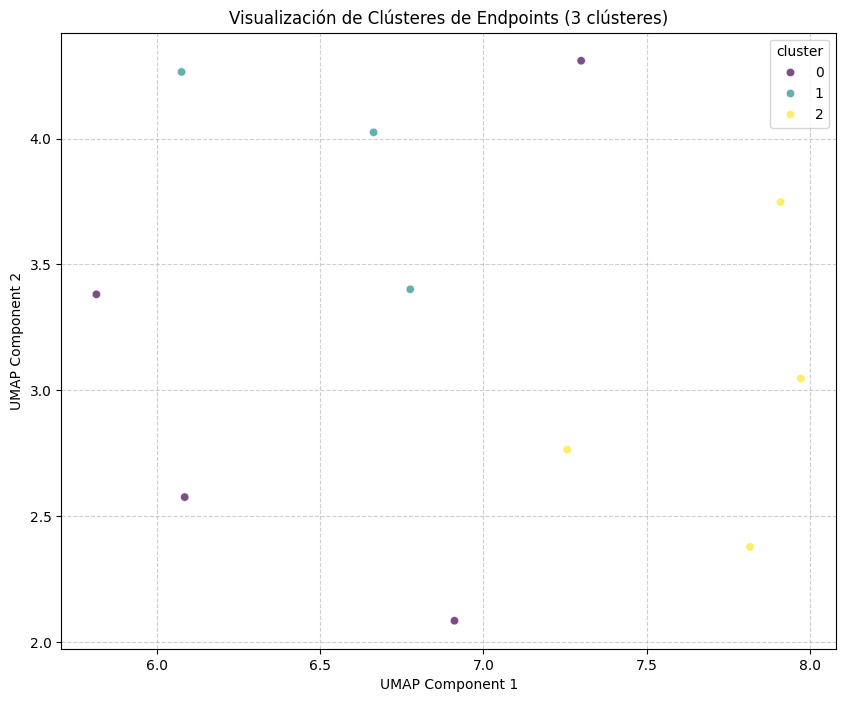

In [ ]:
# --- Análisis y Visualización de los Clústeres ---

print("\nEjemplos de endpoints por clúster:")
for i in range(n_clusters):
    print(f"\n--- Clúster {i} ---")
    cluster_endpoints = df_endpoints[df_endpoints['cluster'] == i]
    # Muestra los primeros 5 endpoints de cada clúster para tener una idea
    for idx, row in cluster_endpoints.iterrows():
        print(f"  ID: {row['endpoint_id']}, Descripción: {row['full_description'][:100]}...") # Limita la descripción para no sobrecargar la salida

# Opcional: Guardar el DataFrame con las etiquetas de clúster
df_endpoints.to_csv("endpoints_clustered.csv", index=False, encoding='utf-8')
print(f"\nDataFrame con clústeres guardado en 'endpoints_clustered.csv'")

# --- Visualización (Opcional, pero muy útil) ---
# Para visualizar los clústeres, primero reducimos la dimensionalidad de los embeddings.
# UMAP o t-SNE son excelentes para esto. Aquí usamos UMAP por su velocidad y preservación de estructura global.
try:
    import umap.umap_ as umap
    reducer = umap.UMAP(random_state=42)
    # Ajustamos y transformamos los embeddings originales (no la matriz de similitud)
    reduced_embeddings = reducer.fit_transform(embeddings_matrix)

    df_endpoints['umap_x'] = reduced_embeddings[:, 0]
    df_endpoints['umap_y'] = reduced_embeddings[:, 1]

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x="umap_x",
        y="umap_y",
        hue="cluster",
        palette="viridis", # O 'Set1', 'tab10', etc.
        data=df_endpoints,
        legend="full",
        alpha=0.7
    )
    plt.title(f'Visualización de Clústeres de Endpoints ({n_clusters} clústeres)')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

except ImportError:
    print("\nInstala 'umap-learn' para la visualización (pip install umap-learn).")
except Exception as e:
    print(f"\nError al generar la visualización UMAP: {e}")

In [1]:
# instalar Sentence-Transformers
!pip install sentence-transformers

# --- Importaciones necesarias ---
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np # Importamos numpy para trabajar mejor con los embeddings

# --- Datos de entrada (casos de uso) ---
sentences = [
    "Browse the Product List",
    "Browse the Catalog",
    "Searching the Catalog",
    "Browse the items List",
    "Add cart Items",
    "Update items in the Cart",
    "Remove items from cart",
    "View Cart Items",
    "Make payment",
    "List Order Items",
    "View Order Status",
    "Confirm Order",
    "Get Total amount",
    "Change Shipping Info ",
    "Signing Up",
    "Signing In",
    "Signout",
    "Manage Item",
    "Manage Account",
    "Manage Order",
    "Manage product/category"
]

# --- Carga del modelo SBERT ---
# Se utiliza 'bert-base-nli-mean-tokens' para obtener embeddings de oraciones.
print("Cargando el modelo SBERT...")
model = SentenceTransformer('bert-base-nli-mean-tokens')
print("Modelo cargado exitosamente.")

# --- Generación de embeddings para cada oración ---
print("\nGenerando embeddings para las oraciones...")
sentence_embeddings = model.encode(sentences)
print(f"Dimensiones de los embeddings: {sentence_embeddings.shape}")
# Esto imprimirá (número_de_oraciones, tamaño_del_embedding), por ejemplo (21, 768)

# --- Cálculo y visualización de la similaridad coseno ---
print("\nCalculando y mostrando similaridad coseno para cada oración:")

# Diccionario para almacenar los resultados: {oracion_base: {oracion_comparada: similaridad}}
all_similarities = {}

for x in range(len(sentences)):
    current_sentence = sentences[x]
    # Calcula la similaridad de la oración actual con todas las demás (incluida ella misma)
    similarities = cosine_similarity(
        [sentence_embeddings[x]], # Se pasa como lista para mantener las dimensiones correctas
        sentence_embeddings
    )[0] # Tomamos el primer (y único) array de resultados

    # Almacena las similaridades para la oración actual
    sentence_similarity_dict = {}
    for y in range(len(sentences)):
        sentence_similarity_dict[sentences[y]] = similarities[y]
    all_similarities[current_sentence] = sentence_similarity_dict

    # Imprime las similaridades ordenadas para la oración actual
    print(f"\n--- Similaridad para la oración: '{current_sentence}' ---")
    # Ordena el diccionario por similaridad de forma descendente
    sorted_similarities = sorted(sentence_similarity_dict.items(), key=lambda item: item[1], reverse=True)

    # Imprime solo los resultados más relevantes (ej. similaridad > 0.5 o top N)
    # Aquí imprimimos todas para replicar tu salida, pero puedes filtrar si la lista es muy larga
    for sentence_compared, score in sorted_similarities:
        # Formateamos el score a 6 decimales para una salida limpia
        print(f"  - '{sentence_compared}': {score:.6f}")

print("\nProceso de cálculo de similaridades completado.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Modelo cargado exitosamente.

Generando embeddings para las oraciones...
Dimensiones de los embeddings: (21, 768)

Calculando y mostrando similaridad coseno para cada oración:

--- Similaridad para la oración: 'Browse the Product List' ---
  - 'Browse the Product List': 1.000000
  - 'Browse the items List': 0.915832
  - 'Browse the Catalog': 0.838526
  - 'Searching the Catalog': 0.773562
  - 'Manage product/category': 0.729370
  - 'View Cart Items': 0.721134
  - 'List Order Items': 0.702705
  - 'Manage Account': 0.690473
  - 'Update items in the Cart': 0.655297
  - 'Manage Item': 0.641974
  - 'View Order Status': 0.597086
  - 'Add cart Items': 0.596059
  - 'Signing Up': 0.582115
  - 'Manage Order': 0.580136
  - 'Signout': 0.576593
  - 'Confirm Order': 0.539919
  - 'Change Shipping Info ': 0.537624
  - 'Signing In': 0.534041
  - 'Make payment': 0.532499
  - 'Get Total amount': 0.437466
  - 'Remove items from cart': 0.423842

--- Similaridad para la oración: 'Browse the Catalog' ---
  - 

In [2]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# --- Datos de entrada (tus oraciones/casos de uso) ---
sentences = [
    "Browse the Product List",
    "Browse the Catalog",
    "Searching the Catalog",
    "Browse the items List",
    "Add cart Items",
    "Update items in the Cart",
    "Remove items from cart",
    "View Cart Items",
    "Make payment",
    "List Order Items",
    "View Order Status",
    "Confirm Order",
    "Get Total amount",
    "Change Shipping Info ",
    "Signing Up",
    "Signing In",
    "Signout",
    "Manage Item",
    "Manage Account",
    "Manage Order",
    "Manage product/category"
]

# --- Carga del modelo SBERT ---
print("Cargando el modelo SBERT 'bert-base-nli-mean-tokens'...")
model = SentenceTransformer('bert-base-nli-mean-tokens')
print("Modelo cargado exitosamente.")

# --- Generación de embeddings para cada oración ---
print("\nGenerando embeddings para las oraciones...")
sentence_embeddings = model.encode(sentences)
print(f"Dimensiones de los embeddings: {sentence_embeddings.shape}")

# --- Imprimir una parte de las sentencias vectorizadas ---
print("\n--- Primeros 3 embeddings de las oraciones (primeros 10 valores de cada vector) ---")
for i in range(3): # Imprime los primeros 3 embeddings
    print(f"Oración '{sentences[i]}':")
    # Imprime solo los primeros 10 valores del vector para no saturar la salida
    # y los formatea a 6 decimales para visibilidad.
    print([f"{x:.6f}" for x in sentence_embeddings[i][:10]]) # Muestra los primeros 10 valores
    print("...") # Indica que el resto del vector está truncado
    print("-" * 50) # Separador para claridad

# --- Construcción de la matriz de similaridad ---
print("\nConstruyendo la matriz de similaridad coseno...")
# Calcula la similaridad del coseno entre todos los pares de embeddings.
# El resultado es una matriz cuadrada donde (i, j) es la similaridad entre la oración i y la oración j.
similarity_matrix = cosine_similarity(sentence_embeddings)
print(f"Dimensiones de la matriz de similaridad: {similarity_matrix.shape}")

# --- Imprimir la matriz de similaridad formateada a 3 decimales ---
print("\n--- Matriz de Similaridad Coseno (Formato: 3 decimales) ---")
# Imprime un encabezado con los índices de las columnas para mejor lectura
header = "       " + " ".join([f"{i: <7}" for i in range(len(sentences))])
print(header)
print("-" * len(header))

for i, row in enumerate(similarity_matrix):
    # Formatea cada valor de la fila a 3 decimales y lo alinea a la derecha en un espacio de 7 caracteres.
    # Esto ayuda a que la matriz se vea más ordenada.
    formatted_row = [f"{value:.3f}" for value in row]
    print(f"{i: <5}  " + " ".join(formatted_row))
print("-" * len(header))

Cargando el modelo SBERT 'bert-base-nli-mean-tokens'...
Modelo cargado exitosamente.

Generando embeddings para las oraciones...
Dimensiones de los embeddings: (21, 768)

--- Primeros 3 embeddings de las oraciones (primeros 10 valores de cada vector) ---
Oración 'Browse the Product List':
['0.405894', '0.017140', '2.048621', '0.199586', '0.031767', '0.065753', '-0.497463', '1.041148', '-0.318941', '0.254877']
...
--------------------------------------------------
Oración 'Browse the Catalog':
['0.076566', '0.141149', '1.358788', '0.275022', '-0.020729', '0.340419', '-0.555105', '1.409416', '-0.775544', '0.455907']
...
--------------------------------------------------
Oración 'Searching the Catalog':
['0.073247', '0.501016', '1.617350', '0.152812', '0.040707', '0.257089', '-0.053002', '0.817623', '-0.735436', '0.237127']
...
--------------------------------------------------

Construyendo la matriz de similaridad coseno...
Dimensiones de la matriz de similaridad: (21, 21)

--- Matriz d


--- Visualización de la Matriz de Distancia (1 - Similaridad) ---


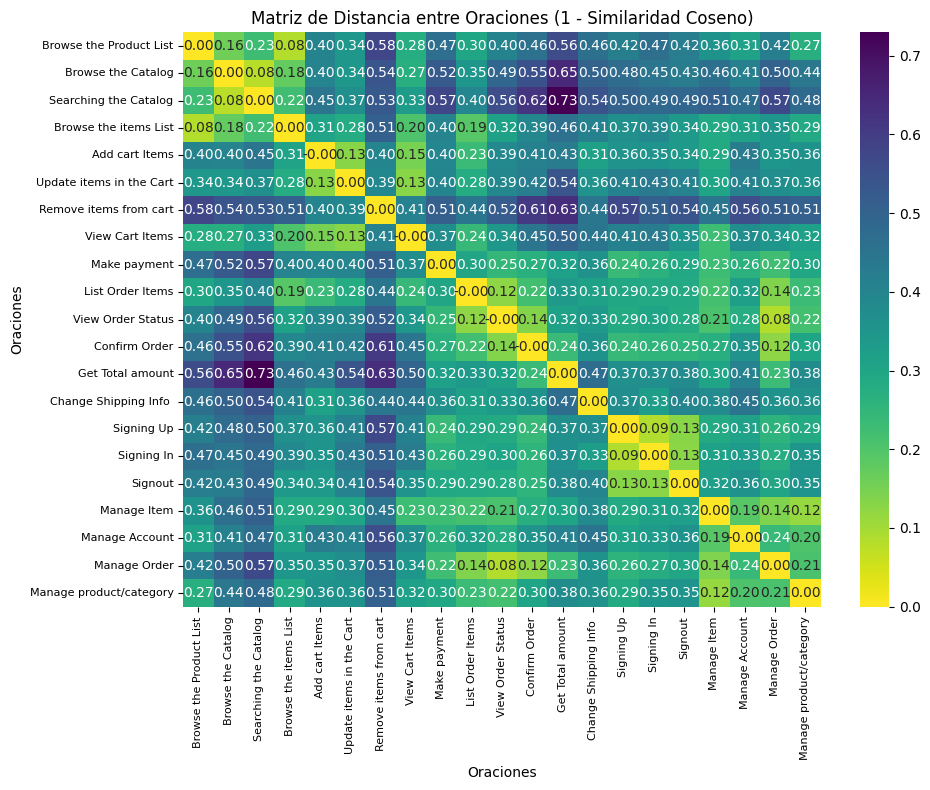


--- Aplicando Clustering Espectral ---

Intentando clustering con 4 clústeres:
Etiquetas de clústeres para 4 clústeres: [2 2 2 2 3 3 3 3 0 0 0 0 0 3 1 1 1 0 0 0 0]

--- Resultados del Clustering Espectral (4 Clústeres) ---

Clúster 2:
  - Browse the Product List
  - Browse the Catalog
  - Searching the Catalog
  - Browse the items List

Clúster 3:
  - Add cart Items
  - Update items in the Cart
  - Remove items from cart
  - View Cart Items
  - Change Shipping Info 

Clúster 0:
  - Make payment
  - List Order Items
  - View Order Status
  - Confirm Order
  - Get Total amount
  - Manage Item
  - Manage Account
  - Manage Order
  - Manage product/category

Clúster 1:
  - Signing Up
  - Signing In
  - Signout

--- Búsqueda del número óptimo de clústeres (usando Silhouette Score) ---
No se pudo calcular para 2 clústeres: Negative values in data passed to `pairwise_distances`. Precomputed distance  need to have non-negative values..
No se pudo calcular para 3 clústeres: Negative values in 

In [4]:
# --- Importaciones adicionales para clustering ---
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score # Asegúrate de que esta importación esté presente

# --- (Asume que las celdas anteriores ya han sido ejecutadas) ---
# Es decir, ya tienes:
# - 'sentences' (tu lista de oraciones)
# - 'sentence_embeddings' (los vectores de tus oraciones)
# - 'similarity_matrix' (la matriz de similaridad coseno)

# --- CORRECCIÓN CRUCIAL: Convertir matriz de similaridad a matriz de distancia ---
# SpectralClustering con affinity='precomputed' y silhouette_score con metric='precomputed'
# esperan una matriz de DISTANCIA, no de similaridad, en la diagonal (0 para sí mismo).
# Para esto, transformamos la similaridad a distancia: distancia = 1 - similaridad.
distance_matrix = 1 - similarity_matrix

print("\n--- Visualización de la Matriz de Distancia (1 - Similaridad) ---")
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=True, cmap='viridis_r', fmt=".2f", # 'viridis_r' para que colores más oscuros sean distancias más bajas
            xticklabels=sentences, yticklabels=sentences)
plt.title('Matriz de Distancia entre Oraciones (1 - Similaridad Coseno)')
plt.xlabel('Oraciones')
plt.ylabel('Oraciones')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()


# --- Aplicación de Clustering Espectral ---
print("\n--- Aplicando Clustering Espectral ---")

# Para SpectralClustering, la matriz de DISTANCIA se usa como la matriz de afinidad.
# Sin embargo, el parámetro 'affinity' todavía debe ser 'precomputed'.
# El algoritmo internamente manejará la matriz de distancia si se le pasa correctamente.
# Es más preciso decir que 'affinity'='precomputed' espera una matriz de afinidad (similaridad),
# y la transformación `1 - similarity_matrix` en realidad la convierte en una matriz que representa
# la disimilaridad. Para `SpectralClustering`, cuando se usa `affinity='precomputed'`, espera
# que los valores más altos representen mayor afinidad (similaridad).
# Por lo tanto, ¡la `similarity_matrix` ORIGINAL es la correcta para `SpectralClustering`!

# El error se produce en `silhouette_score`. Para `silhouette_score` con `metric='precomputed'`,
# sí necesita una matriz de DISTANCIA.

# Entonces, la estrategia es:
# 1. Pasar `similarity_matrix` (original) a `SpectralClustering` con `affinity='precomputed'`.
# 2. Pasar `distance_matrix` (1 - similarity_matrix) a `silhouette_score` con `metric='precomputed'`.

# Opción 1: Número de clústeres fijo (ej. 4)
n_clusters_fixed = 4
print(f"\nIntentando clustering con {n_clusters_fixed} clústeres:")
spectral_model_fixed = SpectralClustering(n_clusters=n_clusters_fixed,
                                          affinity='precomputed', # Aquí usamos la matriz de SIMILARIDAD original
                                          assign_labels='discretize',
                                          random_state=42)

cluster_labels_fixed = spectral_model_fixed.fit_predict(similarity_matrix) # Pasamos similarity_matrix

print(f"Etiquetas de clústeres para {n_clusters_fixed} clústeres: {cluster_labels_fixed}")

# --- Imprimir resultados del clustering fijo ---
print(f"\n--- Resultados del Clustering Espectral ({n_clusters_fixed} Clústeres) ---")
clusters_fixed = {}
for i, label in enumerate(cluster_labels_fixed):
    if label not in clusters_fixed:
        clusters_fixed[label] = []
    clusters_fixed[label].append(sentences[i])

for cluster_id, members in clusters_fixed.items():
    print(f"\nClúster {cluster_id}:")
    for member in members:
        print(f"  - {member}")

# --- (Opcional) Encontrar el número óptimo de clústeres usando el Silhouette Score ---
print("\n--- Búsqueda del número óptimo de clústeres (usando Silhouette Score) ---")

silhouette_scores = []
range_n_clusters = range(2, min(len(sentences) - 1, 10))

for n_clusters in range_n_clusters:
    try:
        # Para calcular el Silhouette Score, necesitas las etiquetas Y la MATRIZ DE DISTANCIA.
        # Primero, ejecuta el clustering espectral con la matriz de SIMILARIDAD.
        spectral_model = SpectralClustering(n_clusters=n_clusters,
                                            affinity='precomputed',
                                            assign_labels='discretize',
                                            random_state=42)
        cluster_labels = spectral_model.fit_predict(similarity_matrix) # Usamos similarity_matrix aquí

        # Luego, calcula el Silhouette Score usando la MATRIZ DE DISTANCIA
        score = silhouette_score(distance_matrix, cluster_labels, metric='precomputed') # Usamos distance_matrix aquí
        silhouette_scores.append(score)
        print(f"Número de clústeres: {n_clusters}, Silhouette Score: {score:.3f}")
    except Exception as e:
        print(f"No se pudo calcular para {n_clusters} clústeres: {e}")
        silhouette_scores.append(np.nan)

if silhouette_scores and not all(np.isnan(score) for score in silhouette_scores):
    # Encuentra el número de clústeres con el Silhouette Score más alto
    best_n_clusters = range_n_clusters[np.nanargmax(silhouette_scores)]
    print(f"\nEl número óptimo de clústeres según Silhouette Score es: {best_n_clusters}")

    # --- Re-aplicar Clustering Espectral con el número óptimo ---
    print(f"\n--- Aplicando Clustering Espectral con {best_n_clusters} Clústeres Óptimos ---")
    optimal_spectral_model = SpectralClustering(n_clusters=best_n_clusters,
                                                affinity='precomputed',
                                                assign_labels='discretize',
                                                random_state=42)
    optimal_cluster_labels = optimal_spectral_model.fit_predict(similarity_matrix) # Usamos similarity_matrix aquí

    print(f"Etiquetas de clústeres óptimas: {optimal_cluster_labels}")

    # --- Imprimir resultados del clustering óptimo ---
    print(f"\n--- Resultados Óptimos del Clustering Espectral ({best_n_clusters} Clústeres) ---")
    optimal_clusters = {}
    for i, label in enumerate(optimal_cluster_labels):
        if label not in optimal_clusters:
            optimal_clusters[label] = []
        optimal_clusters[label].append(sentences[i])

    for cluster_id, members in optimal_clusters.items():
        print(f"\nClúster {cluster_id}:")
        for member in members:
            print(f"  - {member}")
else:
    print("\nNo se pudieron calcular Silhouette Scores válidos o todos son NaN.")